In [ ]:
print("main")

### load Packages

In [1]:
# Standard library imports
import os
import random
import warnings
import logging

# Third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import tensorflow as tf
import gdown
import rpy2.robjects as ro
from rpy2.rinterface import RRuntimeWarning
from rpy2.rinterface_lib.callbacks import logger as rpy2_logger
from pulp import LpSolverDefault
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
# Custom or external package imports
from ddop2.newsvendor import (
    DecisionTreeWeightedNewsvendor, KNeighborsWeightedNewsvendor, 
    SampleAverageApproximationNewsvendor, DeepLearningNewsvendor, 
    RandomForestWeightedNewsvendor, GaussianWeightedNewsvendor, 
    LinearRegressionNewsvendor
)
from drf import drf
from dddex.levelSetKDEx_univariate import LevelSetKDEx
from dddex.loadData import loadDataYaz
from dddex.crossValidation import QuantileCrossValidation, groupedTimeSeriesSplit
from joblib import Parallel, delayed
import pandas as pd
from threadpoolctl import threadpool_limits  # Importiere threadpool_limits


# Set pandas display options
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_colwidth', None)  # Show full column width
pd.set_option('display.max_rows', 10)  # Limit the number of displayed rows
pd.set_option('display.width', 1000)  # Set high enough width to show all columns in a line

# Suppress warnings and logging
warnings.filterwarnings("ignore")  # Suppress all Python warnings
rpy2_logger.setLevel(logging.CRITICAL)  # Only show critical messages from R

# Set R options to suppress warnings and messages
ro.r('while (sink.number() > 0) sink(NULL)')  # Close open sinks to avoid "sink stack full" errors
ro.r('options(warn=-1)')  # Disable all warnings in R
ro.r('suppressMessages(suppressWarnings(library("drf")))')  # Suppress R package messages and warnings

# Set environment variables for R libraries
os.environ['R_LIBS_USER'] = '/usr/lib/R/site-library'
os.environ['R_HOME'] = '/usr/lib/R'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Set random seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
tf.get_logger().setLevel(logging.ERROR)

# Deactivate CBC Solver output
LpSolverDefault.msg = False  # Deactivates the CBC Solver output

# Verify that the current working directory has changed
print("Current working directory:", os.getcwd())

2024-10-24 18:36:57.010709: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-24 18:36:57.016757: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 18:36:57.085168: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-24 18:36:57.086579: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-24 18:36:59.130369: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

Current working directory: /root/WorkingFolder


### load scripts

In [2]:
from scripts.get_data import get_dataset_settings, preprocess_data

from Wrapper.wrapper import DRFWrapper, MLPRegressorWrapper, LevelSetKDExWrapper

from scripts.cv_and_evaluation import pinball_loss, pinball_loss_scorer, preprocess_per_instance, train_and_evaluate_model, calculate_n_iter, bayesian_search_model, preprocess_per_instance, append_result, evaluate_and_append_models, create_cv_folds

from scripts.process_target import process_column

from scripts.get_grids import get_grid

### get data

set configurations in config.py file before we start process

--> set dataset_name before in config file

--> set levelset_calcuations to False if we do the basic models calcuations

In [3]:
import scripts.config as config

dataset_name = config.dataset_name

# Hole die Datei-ID für den gewählten Datensatz
file_id = {
    'bakery': '1r_bDn9Z3Q_XgeTTkJL7352nUG3jkUM0z',
    'yaz': '1xrY3Uv5F9F9ofgSM7dVoSK4bE0gPMg36',
    'm5': '1tCBaxOgE5HHllvLVeRC18zvALBz6B-6w',
    'sid': '1J9bPCfeLDH-mbSnvTHRoCva7pl6cXD3_',
    'air': '1SKPpNxulcusNTjRwCC0p3C_XW7aNBNJZ',
    "copula": '1H5wdJgmxdhbzeS17w0NkRlHRCESEAd-e',
    'wage': '1bn7E7NOoRzE4NwXXs1MYhRSKZHC13qYU',
}[config.dataset_name]


url = f"https://drive.google.com/uc?id={file_id}"


# Datei herunterladen
output = f"{dataset_name}.csv"
gdown.download(url, output, quiet=False)
data = pd.read_csv(output)

# Erstelle die Dataset-Einstellungen basierend auf den geladenen Daten
settings = get_dataset_settings(data)[dataset_name]

y, train_data, test_data, X_train_features, X_test_features, y_train, y_test = preprocess_data(
    data, settings['backscaling_columns'], settings['bool_columns'], settings['drop_columns'])


display(X_train_features.head(30))
display(y_train.head(3))
print(f"Anzahl der Zeilen: {len(y_train)}")
print("Anzahl der targets:", len(y_train.columns))




Downloading...
From: https://drive.google.com/uc?id=1bn7E7NOoRzE4NwXXs1MYhRSKZHC13qYU
To: /root/WorkingFolder/wage.csv
100%|██████████| 3.25M/3.25M [00:00<00:00, 20.9MB/s]


,id,demand,dayIndex,label,age,citizenship,family_size,children,english_level,race_AIAN,race_asian,race_black,race_mix,race_NHOPI,race_other,race_white,hispanic_origin_no,hispanic_origin_yes,nativity_foreign-born,nativity_native,marital_divorced,marital_married,marital_never married,marital_separated,marital_widowed,employer_for-profit company,employer_government,employer_non-profit company,employer_self-employed,economic_region_Abroad,economic_region_Far West,economic_region_Great Lakes,economic_region_Mideast,economic_region_New England,economic_region_Plains,economic_region_Rocky Mountain,economic_region_Southeast,economic_region_Southwest,occupation_11,occupation_13,occupation_15,occupation_17,occupation_19,occupation_21,occupation_23,occupation_25,occupation_27,occupation_29,occupation_31,occupation_33,occupation_35,occupation_37,occupation_39,occupation_41,occupation_43,occupation_45,occupation_47,occupation_49,occupation_51,occupation_53,occupation_55,industry_11,industry_21,industry_22,industry_23,industry_31,industry_41,industry_44,industry_48,industry_51,industry_52,industry_53,industry_54,industry_55,industry_56,industry_61,industry_62,industry_71,industry_72,industry_81,industry_91,male,dayCount
0,16,1.406497,1,train,17,1,2,1,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
1,16,2.322788,2,train,18,1,4,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,2
2,16,2.035106,3,train,18,1,6,2,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,3
3,16,2.436116,4,train,18,1,4,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4
4,16,2.035106,5,train,18,1,2,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15261,22,2.882404,31,train,25,1,1,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,31
15262,22,3.421400,32,train,25,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,32
15264,22,3.076560,34,train,25,1,2,0,0,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,34
15265,22,3.526761,35,train,25,1,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,35


id,16,18,19,20,21,22
dayIndex,,,,,,
1,1.406497,2.610470,2.728253,1.694179,2.362009,2.322788
2,2.322788,1.588819,2.277325,2.574102,2.202502,2.687431
3,2.035106,1.666008,2.585152,1.447319,3.239079,2.823563


Anzahl der Zeilen: 4642
Anzahl der targets: 6


### thread settings 

In [4]:
os.environ['OMP_NUM_THREADS'] = '1'  # OpenMP Threads auf 4 beschränken
os.environ['OPENBLAS_NUM_THREADS'] = '1'  # Für OpenBLAS
os.environ['MKL_NUM_THREADS'] = '1'  # Für Intel MKL (falls verwendet)
os.environ['NUMEXPR_NUM_THREADS'] = '1'  # Für NumExpr
os.environ['VECLIB_MAXIMUM_THREADS'] = '1'  # Für MacOS Accelerate


### process - DDOP Models + Levelset Estimator Models

In [ ]:

# Execution starts here
combinations = [(9, 1), (7.5, 2.5), (5, 5), (2.5, 7.5), (1, 9)]
table_rows = []
random_state = 42

# Initialize cvFolds
cvFolds = None  # Initialization


import scripts.globals as globals  # Import the globals module

for cu, co in combinations:
    print(f"Processing cu, co combination: cu={cu}, co={co}")
    tau = cu / (cu + co)

    # Parallelize column processing within each combination with n_jobs=4 to limit threads
    column_results = Parallel(n_jobs=1)(  
        delayed(process_column)(column, cu, co, tau, y_train, X_train_features, X_test_features, y_test, random_state)
        for column in y_train.columns
    )

    # Combine results from all columns and print after each column
    for result in column_results:
        table_rows.extend(result)
        print(table_rows)
        # Convert the latest result to a DataFrame and print it
        result_table = pd.DataFrame(table_rows, columns=['Variable', 'cu', 'co', 'Model', 'Pinball Loss', 'Best Params', 'delta C', 'sl'])
        print(result_table)  # Print the updated results after each column is processed

# Final result table after processing all combinations
result_table = pd.DataFrame(table_rows, columns=['Variable', 'cu', 'co', 'Model', 'Pinball Loss', 'Best Params', 'delta C', 'sl'])

# Define the folder where results will be saved
results_folder = "results"

# Check if the results folder exists, if not, create it
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Construct the filename using the format "results_basic_Models_{dataset_name}.csv"
filename = os.path.join(results_folder, f"results_basic_Models_{dataset_name}.csv")

# Save the result table to a CSV file in the "results" folder
result_table.to_csv(filename, index=False)

print(f"Results saved as {filename}")

# Aggregate and save cross-validation results at the end of the entire workflow
if globals.global_cv_results:
    # Concatenate all cross-validation results into a single DataFrame
    aggregated_cv_results_df = pd.concat(globals.global_cv_results, ignore_index=True)

    # Print a summary of the aggregated cross-validation data to verify it looks correct
    print("Aggregated cross-validation results sample:")
    print(aggregated_cv_results_df.head(5))  # Print the first 5 rows as a sample

    # Save the aggregated results to a CSV file in the "results" folder
    aggregated_cv_filename = os.path.join(results_folder, f"cv_scores_basic_models_{dataset_name}.csv")
    aggregated_cv_results_df.to_csv(aggregated_cv_filename, index=False)

    print(f"Aggregated cross-validation results saved as {aggregated_cv_filename}")


In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out both 'SAA' and 'LinearRegression' models
filtered_table = result_table[(~result_table['Model'].isin(['SAA', 'LR', 'MLP','LGBM'])) & (result_table['sl'] == 0.9)]

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='Model', y='delta C', data=filtered_table, showfliers=False, width=0.5, color='lightblue')

 #Add the stripplot to show the individual data points
#sns.stripplot(x='Model', y='delta C', data=filtered_table, color='red', jitter=True, size=6, alpha=0.7)

# Add the point plot to show CI based on SD without horizontal lines
sns.pointplot(x="Model", y="delta C", data=filtered_table, ci='sd', color='blue', markers="o", scale=0.7, linestyles="")

# Add title and labels
plt.title('Boxplot, Stripplot, and Pointplot (CI=SD) of Delta C for Each Model (Excluding SAA and LinearRegression)', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Delta C', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

NameError: name 'result_table' is not defined

### process - DRF + Levelset Models

In [4]:
import pandas as pd
from sklearn.model_selection import ParameterGrid
from collections import OrderedDict

timeseries = True

# Execution starts here
combinations = [(9, 1), (7.5, 2.5), (5, 5), (2.5, 7.5), (1, 9)]
table_rows = []
random_state = 1
drf_cv_results = []
global_fold_scores = []

# Iterate over combinations and process them directly
for cu, co in combinations:
    print(f"Processing cu, co combination: cu={cu}, co={co}")
    tau = cu / (cu + co)
    with threadpool_limits(limits=10):
            for column in y_train.columns:
                print(f"Processing column: {column}")

                # Preprocess data
                X_train_scaled, X_test_scaled, y_train_col, y_test_col, X_train_scaled_withID = preprocess_per_instance(
                    column, X_train_features, X_test_features, y_train, y_test
                )
                create_cv_folds(X_train_scaled_withID)
                
                # SAA model evaluation
                saa_model = SampleAverageApproximationNewsvendor(cu, co)
                saa_pred = saa_model.fit(y_train_col).predict(X_test_scaled.shape[0])
                saa_pinball_loss = pinball_loss(y_test_col.values.flatten(), saa_pred, tau)
                append_result(table_rows, column, cu, co, 'SAA', saa_pinball_loss, 'N/A', np.nan, tau)

            
            
                if timeseries:
                    # Initialisiere LGBM und MLP-Modelle
                    lgbm_model = LGBMRegressor(random_state=random_state, n_jobs=1, verbosity=-1)
                    mlp_model = MLPRegressorWrapper(random_state=random_state, early_stopping=True)

                    # LGBM-Modell mit GroupSplitting evaluieren
                    lgbm_model_params = get_grid('LevelSetKDEx_groupsplit', X_train_scaled.shape[1])
                    lgbm_model_evaluation = [
                        ('LS_KDEx_LGBM', LevelSetKDEx(estimator=lgbm_model, binSize=100, weightsByDistance=False), lgbm_model_params)
                    ]
                    evaluate_and_append_models(lgbm_model_evaluation, X_train_scaled, X_test_scaled, y_train_col, y_test_col, saa_pinball_loss, tau, cu, co, column, table_rows, timeseries)

                    # MLP-Modell mit GroupSplitting evaluieren
                    mlp_model_params = get_grid('LevelSetKDEx_groupsplit', X_train_scaled.shape[1])
                    mlp_model_evaluation = [
                        ('LS_KDEx_MLP', LevelSetKDEx(estimator=mlp_model, binSize=100, weightsByDistance=False), mlp_model_params)
                    ]
                    evaluate_and_append_models(mlp_model_evaluation, X_train_scaled, X_test_scaled, y_train_col, y_test_col, saa_pinball_loss, tau, cu, co, column, table_rows, timeseries)


                else:
                    # Although the Wage data set is not a timeseries, it works similarly well on group timeseries splits. 
                    # To do this, we set shuffle = True beforehand in the preprocessing for train/test split. 
                    # Resulting in an mixed order of the train/test points, even if we order it by the "Dayindex" later in the CV splits.
                    # saves the extra work and we can work the same split logic for all datasets
                    print("Only time series Data")

                # DRF-Modell wird immer ausgeführt
                drf_model = DRFWrapper(min_node_size=10, num_trees=100, num_threads=40)
                drf_grid = get_grid('DRF', X_train_scaled.shape[1])
                evaluate_and_append_models([('DRF', drf_model, drf_grid)], X_train_scaled, X_test_scaled, y_train_col, y_test_col, saa_pinball_loss, tau, cu, co, column, table_rows, timeseries)


                # Print the table after evaluating each column
                second_result_table = pd.DataFrame(table_rows, columns=['Variable', 'cu', 'co', 'Model', 'Pinball Loss', 'Best Params', 'delta C', 'sl'])
                print(second_result_table.tail(5))  # Print the last 5 rows of the table after each column is processed


# Define the folder where results will be saved
results_folder = "results"

# Check if the results folder exists, if not, create it
if not os.path.exists(results_folder):
    os.makedirs(results_folder)

# Final result table after processing all combinations
second_result_table = pd.DataFrame(table_rows, columns=['Variable', 'cu', 'co', 'Model', 'Pinball Loss', 'Best Params', 'delta C', 'sl'])

from scripts.globals import global_fold_scores, global_cv_results, drf_cv_results


# Construct the filename and save it in the "results" folder
filename = os.path.join(results_folder, f"results_LevelsetModels_{dataset_name}.csv")
second_result_table.to_csv(filename, index=False)

print(f"Results saved as {filename}")

# Aggregating fold-wise cross-validation results
if global_fold_scores:  # No 'globals' function, just directly use 'global_fold_scores'
    # Reset multi-index for all fold scores
    global_fold_scores_flat = []
    for fold_scores_df in global_fold_scores:
        # Reset the multi-index so that the binSize and weightsByDistance become normal columns
        flat_df = fold_scores_df.reset_index()
        global_fold_scores_flat.append(flat_df)

    # Concatenate all fold-wise cross-validation results into a single DataFrame
    aggregated_fold_scores_df = pd.concat(global_fold_scores_flat, ignore_index=True)

    # Save the aggregated results to a CSV file in the "results" folder
    aggregated_fold_scores_filename = os.path.join(results_folder, f"cv_scores_levelset_models_{dataset_name}.csv")
    aggregated_fold_scores_df.to_csv(aggregated_fold_scores_filename, index=False)

    ### DRF DATA INSERTED INTO THE MAIN TABLE WHERE OTHER BAYES CVs ARE STORED
    aggregated_drf_cv_results_df = pd.concat(drf_cv_results, ignore_index=True)

    # Save the aggregated DRF results to a CSV file in the "results" folder
    aggregated_cv_filename = os.path.join(results_folder, f"cv_drf_scores_{dataset_name}.csv")
    aggregated_drf_cv_results_df.to_csv(aggregated_cv_filename, index=False)


Processing cu, co combination: cu=9, co=1
Processing column: 16
Test length for column: 195 6 % of: 3261
Evaluating model: LS_KDEx_LGBM, cu: 9, co: 1
Performing LevelSetKDEx TimeSeries cross-validation...
Evaluating model: LS_KDEx_MLP, cu: 9, co: 1
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 9, co: 1


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Cross-validation results for DRF with cu=9, co=1:
[0.9]
   Variable  cu  co         Model  Pinball Loss                                                 Best Params   delta C   sl
0        16   9   1           SAA      0.101454                                                         N/A       NaN  0.9
1        16   9   1  LS_KDEx_LGBM      0.083370                {'binSize': 400, 'weightsByDistance': False}  0.178247  0.9
2        16   9   1   LS_KDEx_MLP      0.097717                {'binSize': 400, 'weightsByDistance':

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 9, co: 1
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 9, co: 1


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 9, co: 1
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 9, co: 1


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9][0.9]

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9][0.9]

[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 9, co: 1
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 9, co: 1


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9][0.9]

[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 9, co: 1
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 9, co: 1


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Cross-validation results for DRF with cu=9, co=1:
[0.9]
    Variable  cu  co         Model  Pinball Loss                                                Best Params   delta C   sl
15        20   9   1           DRF      0.079149  {'min_node_size': 8, 'num_features': 79, 'num_trees': 50}  0.129629  0.9
16        21   9   1           SAA      0.127769                                                        N/A       NaN  0.9
17        21   9   1  LS_KDEx_LGBM      0.108954               {'binSize': 100, 'weightsByDistance': False}  0.147256  0.9
18        21   9   1   LS_KDEx_MLP      0.118884               {'binSize': 400, 'weightsByDistance': False}  0.069542  0.9
19        21   9   1           DRF      0.101221   {'min_node_size': 2, 'num_features': 8, 'num_trees': 50}  0.207781  0.9
Processing column: 22
Test length for column: 102 6 % of: 1711
Evaluating model: LS_KDEx_LGBM, cu: 9, co: 1
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 9, co: 1
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 9, co: 1


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 7.5, co: 2.5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 7.5, co: 2.5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9][0.9]

[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Cross-validation results for DRF with cu=7.5, co=2.5:
[0.75]
    Variable   cu   co         Model  Pinball Loss                                                 Best Params   delta C    sl
23        22  9.0  1.0           DRF      0.087293  {'min_node_size': 16, 'num_features': 79, 'num_trees': 50}  0.174071  0.90
24        16  7.5  2.5           SAA      0.180414                                                         N/A       NaN  0.75
25        16  7.5  2.5  LS_KDEx_LGBM      0.149422                {'binSize': 400, 'weightsByDistance': False}  0.171784  0.75
26        16  7.5  2.5   LS_KDEx_MLP      0.171027                {'binSize': 400, 'weightsByDistance': False}  0.052032  0.75
27        16  7.5  2.5           DRF      0.154676  {'min_node_size': 64, 'num_features': 8, 'num_trees': 100}  0.142661  0.75
Pro

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 7.5, co: 2.5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 7.5, co: 2.5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9][0.9]

[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 7.5, co: 2.5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 7.5, co: 2.5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 7.5, co: 2.5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 7.5, co: 2.5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9][0.9]

[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9][0.9]

[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 7.5, co: 2.5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 7.5, co: 2.5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Cross-validation results for DRF with cu=7.5, co=2.5:
[0.75]
    Variable   cu   co         Model  Pinball Loss                                                Best Params   delta C    sl
39        20  7.5  2.5           DRF      0.136642  {'min_node_size': 8, 'num_features': 79, 'num_trees': 50}  0.184024  0.75
40        21  7.5  2.5           SAA      0.220043                                                        N/A       NaN  0.75
41        21  7.5  2.5  LS_KDEx_LGBM      0.168934               {'binSize': 100, 'weightsByDistance': False}  0.232268  0.75
42        21  7.5  2.5   LS_KDEx_MLP      0.195740               {'binSize': 400, 'weightsByDistance': False}  0.110444  0.75
43        21  7.5  2.5           DRF      0.179886   {'min_node_size': 2, 'num_features': 8, 'num_trees': 50}  0.182493  0.75
Processing column: 22
Test length for column: 102 6 % of: 1711
Evaluating model: LS_KDEx_LGBM, cu: 

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 7.5, co: 2.5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 7.5, co: 2.5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9][0.9]

[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 5, co: 5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 5, co: 5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Cross-validation results for DRF with cu=5, co=5:
[0.5]
    Variable   cu   co         Model  Pinball Loss                                                   Best Params   delta C    sl
47        22  7.5  2.5           DRF      0.160440  {'min_node_size': 128, 'num_features': 79, 'num_trees': 500}  0.128926  0.75
48        16  5.0  5.0           SAA      0.227482                                                           N/A       NaN  0.50
49        16  5.0  5.0  LS_KDEx_LGBM      0.188760                  {'binSize': 100, 'weightsByDistance': False}  0.170220  0.50
50        16  5.0  5.0   LS_KDEx_MLP      0.211234                  {'binSize': 400, 'weightsByDistance': False}  0.071428  0.50
51        16  5.0  5.0           DRF      0.194674  {'min_node_size': 128, 'num_features': 79, 'num_trees': 100}  0.144224  0.50
Processing column: 18
Test length for column: 64 6 % of: 1080
Evaluating model: LS_KDEx_LGBM, cu: 5, co: 5
Performin

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 5, co: 5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 5, co: 5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 5, co: 5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 5, co: 5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 5, co: 5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 5, co: 5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 5, co: 5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 5, co: 5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Cross-validation results for DRF with cu=5, co=5:
[0.5]
    Variable   cu   co         Model  Pinball Loss                                                Best Params   delta C   sl
63        20  5.0  5.0           DRF      0.169468   {'min_node_size': 2, 'num_features': 8, 'num_trees': 50}  0.201092  0.5
64        21  5.0  5.0           SAA      0.279745                                                        N/A       NaN  0.5
65        21  5.0  5.0  LS_KDEx_LGBM      0.213250               {'binSize': 100, 'weightsByDistance': False}  0.237696  0.5
66        21  5.0  5.0   LS_KDEx_MLP      0.241525               {'binSize': 400, 'weightsByDistance': False}  0.136621  0.5
67        21  5.0  5.0           DRF      0.227944  {'min_node_size': 2, 'num_features': 79, 'num_trees': 50}  0.185172  0.5
Processing column: 22
Test length for column: 102 6 % of: 1711
Evaluating model: LS_KDEx_LGBM, cu: 5, co: 5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 5, co: 5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 5, co: 5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9][0.9]
[0.9]

[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9][0.9]

[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 2.5, co: 7.5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 2.5, co: 7.5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9][0.9]

[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 2.5, co: 7.5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 2.5, co: 7.5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9][0.9]

[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 2.5, co: 7.5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 2.5, co: 7.5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 2.5, co: 7.5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 2.5, co: 7.5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9][0.9]

[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9][0.9]

[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 2.5, co: 7.5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 2.5, co: 7.5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9][0.9]

[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9][0.9]

[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
Cross-validation results for DRF with cu=2.5, co=7.5:
[0.25]
    Variable   cu   co         Model  Pinball Loss                                                Best Params   delta C    sl
87        20  2.5  7.5           DRF      0.145212   {'min_node_size': 2, 'num_features': 8, 'num_trees': 50}  0.167504  0.25
88        21  2.5  7.5           SAA      0.227401                                                        N/A       NaN  0.25
89        21  2.5  7.5  LS_KDEx_LGBM      0.185158               {'binSize': 400, 'weightsByDistance': False}  0.185765  0.25
90        21  2.5  7.5   LS_KDEx_MLP      0.205878               {'binSize': 400, 'weightsByDistance': False}  0.094648  0.25
91        21  2.5  7.5           DRF      0.189006  {'min_node_size': 1, 'num_features': 79, 'num_trees': 50}  0.168842  0.25
Processing column: 22
Test length for column: 102 6 % of: 1711
Evaluating model: LS_KDEx_LGBM, cu: 2.5, co: 7.5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 2.5, co: 7.5
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 2.5, co: 7.5


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9][0.9]

[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 1, co: 9
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 1, co: 9


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9][0.9]

[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 1, co: 9
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 1, co: 9


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 1, co: 9
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 1, co: 9


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 1, co: 9
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 1, co: 9


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 1, co: 9
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 1, co: 9


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Cross-validation results for DRF with cu=1, co=9:
[0.1]
     Variable   cu   co         Model  Pinball Loss                                                Best Params   delta C   sl
111        20  1.0  9.0           DRF      0.088706   {'min_node_size': 2, 'num_features': 8, 'num_trees': 50}  0.113923  0.1
112        21  1.0  9.0           SAA      0.132613                                                        N/A       NaN  0.1
113        21  1.0  9.0  LS_KDEx_LGBM      0.118020               {'binSize': 400, 'weightsByDistance': False}  0.110043  0.1
114        21  1.0  9.0   LS_KDEx_MLP      0.134385               {'binSize': 400, 'weightsByDistance': False} -0.013364  0.1
115        21  1.0  9.0           DRF      0.117641  {'min_node_size': 2, 'num_features': 79, 'num_trees': 50}  0.112895  0.1
Processing column: 22
Test length for column: 102 6 % of: 1711
Evaluating model: LS_KDEx_LGBM, cu: 1, co: 9
Performi

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: LS_KDEx_MLP, cu: 1, co: 9
Performing LevelSetKDEx TimeSeries cross-validation...


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

Evaluating model: DRF, cu: 1, co: 9


R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages



Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[0.9]
[

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[write to console]: 2: 
R[write to console]: In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
R[write to console]: 
 
R[write to console]:  library ‘/usr/lib/R/site-library’ contains no packages

R[wr

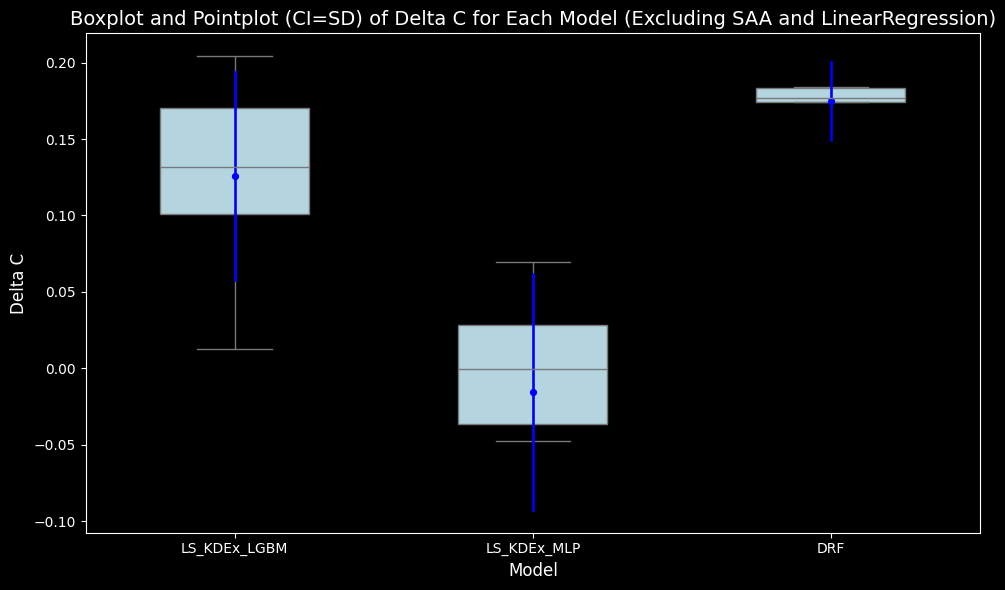

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter out specific models and only include rows where 'sl' equals 0.9
filtered_table = second_result_table[
    (~second_result_table['Model'].isin(['SAA', 'LR', 'MLP', 'LGBM'])) & 
    (second_result_table['sl'] == 0.9)
]

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='Model', y='delta C', data=filtered_table, showfliers=False, width=0.5, color='lightblue')

# Add the point plot to show CI based on SD without horizontal lines
sns.pointplot(x="Model", y="delta C", data=filtered_table, ci='sd', color='blue', markers="o", scale=0.7, linestyles="")

# Add title and labels
plt.title('Boxplot and Pointplot (CI=SD) of Delta C for Each Model (Excluding SAA and LinearRegression)', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Delta C', fontsize=12)

# Show the plot with tight layout
plt.tight_layout()
plt.show()
